In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import csv
import statistics
from statistics import mode
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score
)


In [5]:
#COMBINING ALL THE DATA

def load_clean_wb(path, colname):
    with open(path, encoding="utf-8") as f:
        lines = f.readlines()[4:]
    rows = [r for r in csv.reader(lines, quotechar='"', delimiter=',') if len(r) > 63]
    countries = [r[0].replace('"', '') for r in rows]
    values = [r[59:64] for r in rows]
    df = pd.DataFrame(values, columns=["2015", "2016", "2017", "2018", "2019"])
    df.insert(0, "Country", countries)
    df = df.melt(id_vars="Country", var_name="Year", value_name=colname)
    df[colname] = pd.to_numeric(df[colname], errors="coerce")
    return df

def load_whi(path, year, country_col, score_col):
    df = pd.read_csv(path)
    df = df.rename(columns={country_col: "Country", score_col: "Happiness Score"})
    df = df[["Country", "Happiness Score"]]
    df["Year"] = year
    return df

whi_2015 = load_whi("2015.csv", "2015", "Country", "Happiness Score")
whi_2016 = load_whi("2016.csv", "2016", "Country", "Happiness Score")
whi_2017 = load_whi("2017.csv", "2017", "Country", "Happiness.Score")
whi_2018 = load_whi("2018.csv", "2018", "Country or region", "Score")
whi_2019 = load_whi("2019.csv", "2019", "Country or region", "Score")
whi_df = pd.concat([whi_2015, whi_2016, whi_2017, whi_2018, whi_2019])

edu = load_clean_wb("API_SE.TER.ENRR_DS2_en_csv_v2_23897.csv", "Tertiary Enrollment")
pollution = load_clean_wb("API_EN.ATM.PM25.MC.M3_DS2_en_csv_v2_87588.csv", "Air Pollution")
forest = load_clean_wb("API_AG.LND.FRST.ZS_DS2_en_csv_v2_85151.csv", "Forest Land")
arable = load_clean_wb("API_AG.LND.ARBL.ZS_DS2_en_csv_v2_87396.csv", "Arable Land")

coast = pd.read_csv("coastlines.csv")
coast = coast.rename(columns={"country": "Country", "coast_to_area_wf": "Coastline"})
coast = coast[["Country", "Coastline"]]

final_clean = whi_df.merge(edu, on=["Country", "Year"], how="left") \
    .merge(pollution, on=["Country", "Year"], how="left") \
    .merge(forest, on=["Country", "Year"], how="left") \
    .merge(coast, on="Country", how="left") \
    .merge(arable, on=["Country", "Year"], how="left")

final_clean.to_csv("final_merged_dataset_2015_2019.csv", index=False)


# Regression Analysis

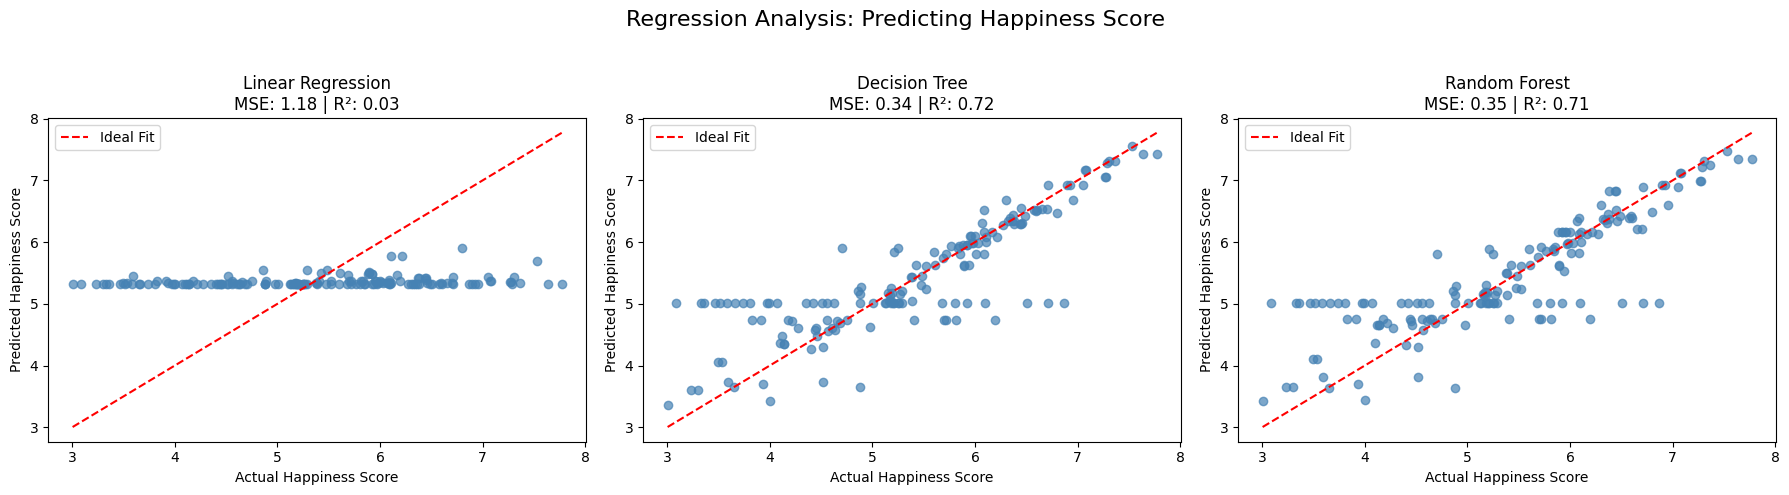

In [6]:


def load_clean_wb(path, colname):
    with open(path, encoding="utf-8") as f:
        lines = f.readlines()[4:]
    rows = [r for r in csv.reader(lines, quotechar='"', delimiter=',') if len(r) > 63]
    countries = [r[0].replace('"', '') for r in rows]
    values = [r[59:64] for r in rows]
    df = pd.DataFrame(values, columns=["2015", "2016", "2017", "2018", "2019"])
    df.insert(0, "Country", countries)
    df = df.melt(id_vars="Country", var_name="Year", value_name=colname)
    df[colname] = pd.to_numeric(df[colname], errors="coerce")
    return df

def load_whi(path, year, country_col, score_col):
    df = pd.read_csv(path)
    df = df.rename(columns={country_col: "Country", score_col: "Happiness Score"})
    df = df[["Country", "Happiness Score"]]
    df["Year"] = year
    return df

whi_2015 = load_whi("2015.csv", "2015", "Country", "Happiness Score")
whi_2016 = load_whi("2016.csv", "2016", "Country", "Happiness Score")
whi_2017 = load_whi("2017.csv", "2017", "Country", "Happiness.Score")
whi_2018 = load_whi("2018.csv", "2018", "Country or region", "Score")
whi_2019 = load_whi("2019.csv", "2019", "Country or region", "Score")
whi_df = pd.concat([whi_2015, whi_2016, whi_2017, whi_2018, whi_2019])

edu = load_clean_wb("API_SE.TER.ENRR_DS2_en_csv_v2_23897.csv", "Tertiary Enrollment")
pollution = load_clean_wb("API_EN.ATM.PM25.MC.M3_DS2_en_csv_v2_87588.csv", "Air Pollution")
forest = load_clean_wb("API_AG.LND.FRST.ZS_DS2_en_csv_v2_85151.csv", "Forest Land")
arable = load_clean_wb("API_AG.LND.ARBL.ZS_DS2_en_csv_v2_87396.csv", "Arable Land")

coast = pd.read_csv("coastlines.csv")
coast = coast.rename(columns={"country": "Country", "coast_to_area_wf": "Coastline"})
coast = coast[["Country", "Coastline"]]

final_clean = whi_df.merge(edu, on=["Country", "Year"], how="left") \
    .merge(pollution, on=["Country", "Year"], how="left") \
    .merge(forest, on=["Country", "Year"], how="left") \
    .merge(coast, on="Country", how="left") \
    .merge(arable, on=["Country", "Year"], how="left")

cols_to_fill = ["Happiness Score", "Tertiary Enrollment", "Air Pollution", "Forest Land", "Coastline", "Arable Land"]
final_clean[cols_to_fill] = final_clean[cols_to_fill].fillna(final_clean[cols_to_fill].mean())
final_clean[cols_to_fill] = final_clean[cols_to_fill].fillna(0)

X = final_clean[["Tertiary Enrollment", "Air Pollution", "Forest Land", "Coastline", "Arable Land"]]
y = final_clean["Happiness Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R2": r2}
    predictions[name] = y_pred

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, y_pred) in enumerate(predictions.items()):
    axs[i].scatter(y_test, y_pred, alpha=0.7, color='steelblue')
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
    axs[i].set_title(f"{name}\nMSE: {results[name]['MSE']:.2f} | R²: {results[name]['R2']:.2f}")
    axs[i].set_xlabel("Actual Happiness Score")
    axs[i].set_ylabel("Predicted Happiness Score")
    axs[i].legend()

plt.suptitle("Regression Analysis: Predicting Happiness Score", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Comparison of Average Actual vs Predicted Happiness Scores

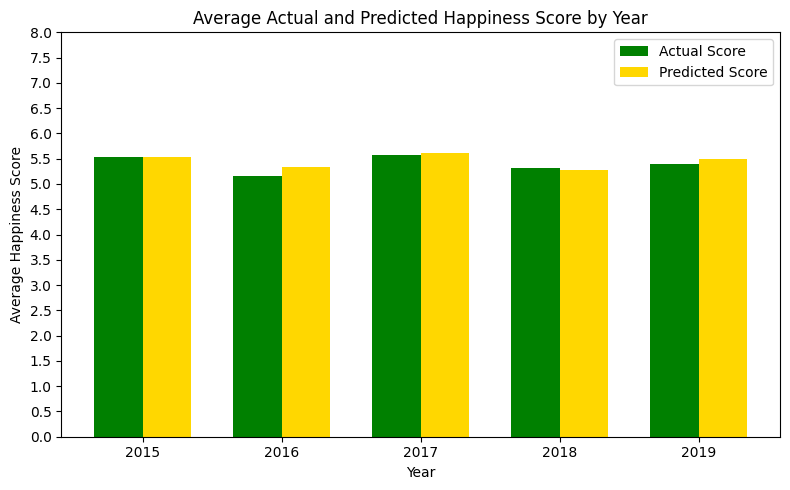

In [7]:

df = pd.read_csv("final_merged_dataset_2015_2019.csv")

cols = ["Tertiary Enrollment", "Air Pollution", "Forest Land", "Coastline", "Arable Land", "Happiness Score"]
df[cols] = df[cols].fillna(df[cols].mean())

X = df[["Tertiary Enrollment", "Air Pollution", "Forest Land", "Coastline", "Arable Land"]]
y = df["Happiness Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

df["Predicted Score"] = np.nan
df.loc[X_test.index, "Predicted Score"] = model.predict(X_test)

bar_data = df.dropna(subset=["Predicted Score"]).groupby("Year")[["Happiness Score", "Predicted Score"]].mean().reset_index()

x = np.arange(len(bar_data["Year"]))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, bar_data["Happiness Score"], width, label='Actual Score', color='green')
ax.bar(x + width/2, bar_data["Predicted Score"], width, label='Predicted Score', color='gold')

ax.set_ylabel("Average Happiness Score")
ax.set_xlabel("Year")
ax.set_title("Average Actual and Predicted Happiness Score by Year")
ax.set_xticks(x)
ax.set_xticklabels(bar_data["Year"])
ax.set_yticks(np.arange(0, 8.5, 0.5))
ax.legend()

plt.tight_layout()
plt.show()


# Confusion Matrix for Binned Happiness Score

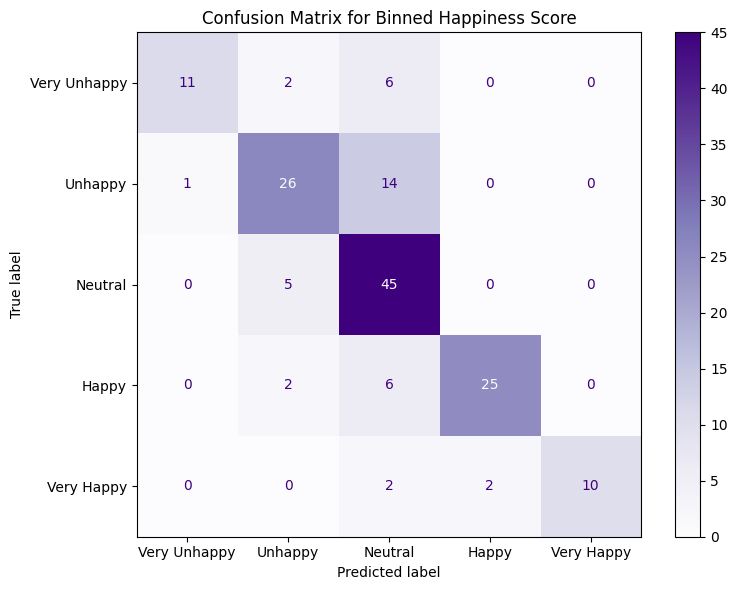

Very Unhappy: 0–4
 Unhappy: 4–5
 Neutral: 5–6
 Happy: 6–7
 Very Happy: 7–10


In [8]:


df = pd.read_csv("final_merged_dataset_2015_2019.csv")

cols = ["Tertiary Enrollment", "Air Pollution", "Forest Land", "Coastline", "Arable Land", "Happiness Score"]
df[cols] = df[cols].fillna(df[cols].mean())

bins = [0, 4, 5, 6, 7, 10]
labels = ['Very Unhappy', 'Unhappy', 'Neutral', 'Happy', 'Very Happy']
df["Happiness Binned"] = pd.cut(df["Happiness Score"], bins=bins, labels=labels)

X = df[["Tertiary Enrollment", "Air Pollution", "Forest Land", "Coastline", "Arable Land"]]
y = df["Happiness Binned"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Purples')
plt.title("Confusion Matrix for Binned Happiness Score")
plt.tight_layout()
plt.show()

print ("Very Unhappy: 0–4\n",
    "Unhappy: 4–5\n",
    "Neutral: 5–6\n",
    "Happy: 6–7\n",
    "Very Happy: 7–10")